In [38]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import genfromtxt
from sklearn import datasets
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

from qiskit.algorithms.optimizers import ADAM, SPSA, COBYLA
from qiskit import QuantumCircuit
from qiskit.circuit import QuantumRegister, ClassicalRegister
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import TwoLocal, PauliFeatureMap, ZFeatureMap, ZZFeatureMap
from qiskit.primitives import BackendEstimator, BackendSampler
from qiskit.quantum_info import Pauli, SparsePauliOp
from qiskit_aer import AerSimulator
from qiskit_algorithms.gradients import ParamShiftEstimatorGradient, ParamShiftSamplerGradient

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from qiskit_machine_learning.utils.loss_functions import CrossEntropyLoss
import csv
from IPython.display import clear_output

In [84]:
SEED = 124
qasm_sim = AerSimulator()

# Dataset

In [3]:
my_data = genfromtxt('MNIST_CSV/mnist_train.csv', delimiter=',')

5.0
[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.1875, 10.125, 22.9375, 23.375, 0.0], [0.0, 0.0, 39.625, 159.3125, 137.4375, 56.6875, 18.625, 0.0], [0.0, 0.0, 0.0, 64.75, 35.3125, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 83.6875, 75.5, 0.0, 0.0], [0.0, 0.0, 1.4375, 69.8125, 149.0625, 60.75, 0.0, 0.0], [0.0, 11.9375, 116.125, 96.0625, 5.5625, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]


<Figure size 640x480 with 0 Axes>

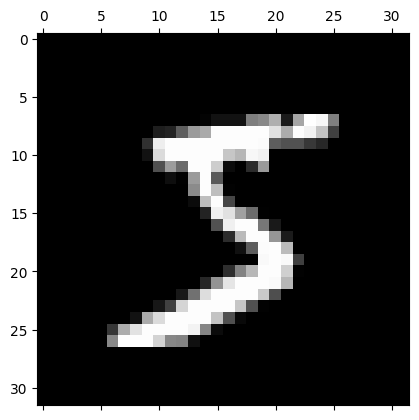

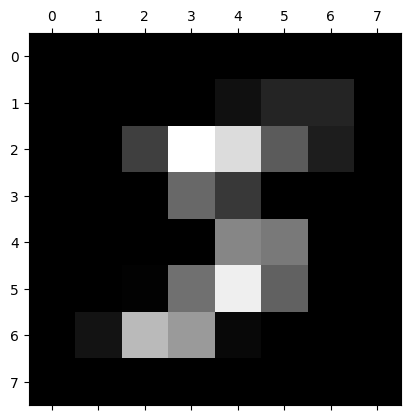

In [4]:
image = []
idx = 0
label = my_data[idx][0]
print(label)
image.append(np.zeros(32))
image.append(np.zeros(32))
for i in range(28):
    row = []
    row.append(0)
    row.append(0)
    for j in range(28):
        row.append(my_data[idx][i*28+j+1])
    row.append(0)
    row.append(0)
    image.append(row)
image.append(np.zeros(32))
image.append(np.zeros(32))
image_shrink = []

for i in range(8):
    row = []
    for j in range(8):
        row.append(sum(image[i*4][j*4:j*4+3])/16+sum(image[i*4+1][j*4:j*4+3])/16
                   +sum(image[i*4+2][j*4:j*4+3])/16+sum(image[i*4+3][j*4:j*4+3])/16)
    image_shrink.append(row)
    
print(image_shrink)
plt.gray()
plt.matshow(image)
plt.matshow(image_shrink)
plt.show()

[[  0.       0.       0.       0.       0.       0.       0.       0.    ]
 [  0.       0.       0.       0.      46.75    43.625    0.       0.    ]
 [  0.       0.       0.      64.1875 175.1875 128.125    0.       0.    ]
 [  0.       0.      33.25   114.3125  13.      63.25    37.8125   0.    ]
 [  0.       0.     134.5      0.       0.      94.4375  22.25     0.    ]
 [  0.       0.     138.8125  53.625  104.9375  40.1875   0.       0.    ]
 [  0.       0.      39.5     87.6875   9.0625   0.       0.       0.    ]
 [  0.       0.       0.       0.       0.       0.       0.       0.    ]]


<Figure size 1200x600 with 0 Axes>

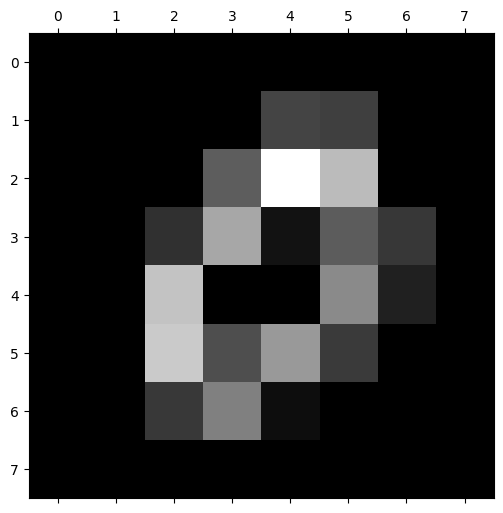

In [80]:
x_list = []
y_list = []
threshold = 100
cnt = 0
for idx in range(len(my_data)):
    image = []
    label = my_data[idx][0]
    if (label==0 or label==1):
            image = np.append(image,np.zeros(64))
            for i in range(28):
                row = my_data[idx][i*28+1:i*28+29]
                row = np.insert(row,0,(0,0))
                row = np.append(row,(0,0))
                image = np.append(image,row)
            image = np.append(image,np.zeros(64))
            image_shrink = []
            for i in range(8):
                row_shrink = []
                for j in range(8):
                    row_shrink = np.append(row_shrink,sum(image[i*4*32+j*4:i*4*32+j*4+3])/16
                                           +sum(image[(i*4+1)*32+j*4:(i*4+1)*32+j*4+3])/16
                                           +sum(image[(i*4+2)*32+j*4:(i*4+2)*32+j*4+3])/16
                                           +sum(image[(i*4+3)*32+j*4:(i*4+3)*32+j*4+3])/16) 
                image_shrink = np.append(image_shrink,row_shrink)  
            x_list.append(image_shrink)
            y_list.append(label)
            cnt = cnt + 1
            if (cnt==threshold):
                break
                
x_img = np.array(x_list)
y = np.array(y_list)
#for i in range(len(x_list)):
#    x[i] = x[i]/sum(x[i])
#    x[i] = np.sqrt(x[i])
    
x_img_real = np.reshape(x_img[0],[8,8])
print(x_img_real)
plt.gray()
plt.matshow(x_img_real)
plt.show()

In [82]:
#Vertical encoding
x = []
for idx in range(len(x_img)):
    row = []
    for i in range(4):
        row = np.append(row,sum(x_img[idx][i*2:i*2+1])+sum(x_img[idx][i*2+8:i*2+9])
                +sum(x_img[idx][i*2+8*2:i*2+8*2+1])+sum(x_img[idx][i*2+8*3:i*2+8*3+1])
                +sum(x_img[idx][i*2+8*4:i*2+8*4+1])+sum(x_img[idx][i*2+8*5:i*2+8*5+1])
                +sum(x_img[idx][i*2+8*6:i*2+8*6+1])+sum(x_img[idx][i*2+8*7:i*2+8*7+1]))
    for i in range(2):
        row = np.append(row,sum(x_img[idx][i*32:i*32+7])+sum(x_img[idx][i*32+8:i*32+8+7])
             +sum(x_img[idx][i*32+8*2:i*32+8*2+7])+sum(x_img[idx][i*32+8*3:i*32+8*3+7]))
    x.append(row)
    
for i in range(len(x_img)):
    x[i] = x[i]/sum(x[i])
    x[i] = np.sqrt(x[i])

x = np.array(x)

In [83]:
test_ratio = 0.2
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=SEED, stratify=y)
num_classes = 2
num_features = 6

print(f"Train set size: {len(x_train)}")
print(f"Test set size:  {len(x_test)}")

Train set size: 80
Test set size:  20


# Data embedding circuits

In [ ]:
def initialize_circuit(params):
    target = QuantumCircuit(6)
    target.initialize(params, range(6))
    return target

params = x_train[0]
circuit = initialize_circuit(params)
circuit.draw()

In [ ]:
class CustomFeatureMap(ZZFeatureMap):
    """Mapping data with a custom feature map."""
    def __init__(
        self,
        feature_dimension=6,
        name: str = "CustomFeatureMap",
    ):
        super(CustomFeatureMap,self).__init__(feature_dimension=feature_dimension)
        parameters = np.zeros(64)
    
    def construct_circuit(self, x, qr, inverse=False):
        """Construct the feature map circuit.
        
        Args:
            x (numpy.ndarray): 1-D to-be-transformed data.
            qr (QauntumRegister): the QuantumRegister object for the circuit.
            inverse (bool): whether or not to invert the circuit.
            
        Returns:
            QuantumCircuit: a quantum circuit transforming data x.
        """
        qc = QuantumCircuit(qr)
        qc = initialize_circuit(x)        
       
        return qc

In [48]:
def get_zz_feature_map(feature_dim, feature_map_rep, ent):
    return ZZFeatureMap(feature_dimension=feature_dim, reps=feature_map_rep, entanglement=ent)

fmap_zz = get_zz_feature_map(num_features, 2, 'linear')
input_params = fmap_zz.parameters
fmap_zz.decompose().draw()#'mpl', scale=0.7)

┌───┐┌─────────────┐                                          ┌───┐»
q_0: ┤ H ├┤ P(2.0*x[0]) ├──■────────────────────────────────────■──┤ H ├»
     ├───┤├─────────────┤┌─┴─┐┌──────────────────────────────┐┌─┴─┐└───┘»
q_1: ┤ H ├┤ P(2.0*x[1]) ├┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├┤ X ├──■──»
     ├───┤├─────────────┤└───┘└──────────────────────────────┘└───┘┌─┴─┐»
q_2: ┤ H ├┤ P(2.0*x[2]) ├──────────────────────────────────────────┤ X ├»
     ├───┤├─────────────┤                                          └───┘»
q_3: ┤ H ├┤ P(2.0*x[3]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_4: ┤ H ├┤ P(2.0*x[4]) ├───────────────────────────────────────────────»
     ├───┤├─────────────┤                                               »
q_5: ┤ H ├┤ P(2.0*x[5]) ├───────────────────────────────────────────────»
     └───┘└─────────────┘                                               »
«             ┌─────────────┐                   »
«q_0: ────────┤ P(2.0*x[0]) ├───────────────────»
«             └─────────────┘              ┌───┐»
«q_1: ──────────────────────────────────■──┤ H ├»
«     ┌──────────────────────────────┐┌─┴─┐└───┘»
«q_2: ┤ P(2.0*(π - x[1])*(π - x[2])) ├┤ X ├──■──»
«     └──────────────────────────────┘└───┘┌─┴─┐»
«q_3: ─────────────────────────────────────┤ X ├»
«                                          └───┘»
«q_4: ──────────────────────────────────────────»
«                                               »
«q_5: ──────────────────────────────────────────»
«                                               »
«                                                                          »
«q_0: ──────────────────────────────────■──────────────────────────────────»
«             ┌─────────────┐         ┌─┴─┐┌──────────────────────────────┐»
«q_1: ────────┤ P(2.0*x[1]) ├─────────┤ X ├┤ P(2.0*(π - x[0])*(π - x[1])) ├»
«             └─────────────┘         └───┘└────────────┬───┬─────────────┘»
«q_2: ──────────────────────────────────■───────────────┤ H ├──────────────»
«     ┌──────────────────────────────┐┌─┴─┐             └───┘              »
«q_3: ┤ P(2.0*(π - x[2])*(π - x[3])) ├┤ X ├───────────────■────────────────»
«     └──────────────────────────────┘└───┘             ┌─┴─┐              »
«q_4: ──────────────────────────────────────────────────┤ X ├──────────────»
«                                                       └───┘              »
«q_5: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«                                                                          »
«q_0: ───────────────■─────────────────────────────────────────────────────»
«                  ┌─┴─┐                                                   »
«q_1: ─────────────┤ X ├────────────────■──────────────────────────────────»
«             ┌────┴───┴────┐         ┌─┴─┐┌──────────────────────────────┐»
«q_2: ────────┤ P(2.0*x[2]) ├─────────┤ X ├┤ P(2.0*(π - x[1])*(π - x[2])) ├»
«             └─────────────┘         └───┘└────────────┬───┬─────────────┘»
«q_3: ──────────────────────────────────■───────────────┤ H ├──────────────»
«     ┌──────────────────────────────┐┌─┴─┐             └───┘              »
«q_4: ┤ P(2.0*(π - x[3])*(π - x[4])) ├┤ X ├───────────────■────────────────»
«     └──────────────────────────────┘└───┘             ┌─┴─┐              »
«q_5: ──────────────────────────────────────────────────┤ X ├──────────────»
«                                                       └───┘              »
«                                                                          »
«q_0: ─────────────────────────────────────────────────────────────────────»
«                                                                          »
«q_1: ───────────────■─────────────────────────────────────────────────────»
«                  ┌─┴─┐                                                   »
«q_2: 

In [49]:
fmap_zz.assign_parameters({k:v for (k,v) in zip(fmap_zz.parameters, x[0])}).decompose().draw()#'mpl', scale=0.7)

┌───┐   ┌──────┐                          ┌───┐  ┌──────┐            »
q_0: ┤ H ├───┤ P(0) ├─────■─────────────────■──┤ H ├──┤ P(0) ├────────────»
     ├───┤┌──┴──────┴─┐ ┌─┴─┐┌───────────┐┌─┴─┐└───┘  └──────┘       ┌───┐»
q_1: ┤ H ├┤ P(0.7933) ├─┤ X ├┤ P(17.247) ├┤ X ├──■────────────────■──┤ H ├»
     ├───┤├───────────┴┐└───┘└───────────┘└───┘┌─┴─┐┌──────────┐┌─┴─┐└───┘»
q_2: ┤ H ├┤ P(0.79659) ├───────────────────────┤ X ├┤ P(15.06) ├┤ X ├──■──»
     ├───┤├────────────┤                       └───┘└──────────┘└───┘┌─┴─┐»
q_3: ┤ H ├┤ P(0.33049) ├─────────────────────────────────────────────┤ X ├»
     ├───┤├───────────┬┘                                             └───┘»
q_4: ┤ H ├┤ P(1.1439) ├───────────────────────────────────────────────────»
     ├───┤├───────────┤                                                   »
q_5: ┤ H ├┤ P(1.1482) ├───────────────────────────────────────────────────»
     └───┘└───────────┘                                                   »
«                                                                   »
«q_0: ───────────────■─────────────────────■────────────────────────»
«     ┌───────────┐┌─┴─┐┌───────────┐    ┌─┴─┐                      »
«q_1: ┤ P(0.7933) ├┤ X ├┤ P(17.247) ├────┤ X ├───────■──────────────»
«     └───────────┘└───┘└───┬───┬───┘┌───┴───┴────┐┌─┴─┐┌──────────┐»
«q_2: ───────────────■──────┤ H ├────┤ P(0.79659) ├┤ X ├┤ P(15.06) ├»
«      ┌──────────┐┌─┴─┐    └───┘    └────────────┘└───┘└──┬───┬───┘»
«q_3: ─┤ P(16.33) ├┤ X ├──────■──────────────────────■─────┤ H ├────»
«      └──────────┘└───┘    ┌─┴─┐    ┌───────────┐ ┌─┴─┐   └───┘    »
«q_4: ──────────────────────┤ X ├────┤ P(15.296) ├─┤ X ├─────■──────»
«                           └───┘    └───────────┘ └───┘   ┌─┴─┐    »
«q_5: ─────────────────────────────────────────────────────┤ X ├────»
«                                                          └───┘    »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ──────■─────────────────────────────────────────────────────────────────»
«         ┌─┴─┐                                                               »
«q_2: ────┤ X ├───────■────────────────────■──────────────────────────────────»
«     ┌───┴───┴────┐┌─┴─┐┌──────────┐    ┌─┴─┐                                »
«q_3: ┤ P(0.33049) ├┤ X ├┤ P(16.33) ├────┤ X ├──────■─────────────────■───────»
«     └────────────┘└───┘└──┬───┬───┘┌───┴───┴───┐┌─┴─┐┌───────────┐┌─┴─┐     »
«q_4: ────────────────■─────┤ H ├────┤ P(1.1439) ├┤ X ├┤ P(15.296) ├┤ X ├──■──»
«     ┌───────────┐ ┌─┴─┐   ├───┤    ├───────────┤└───┘└───────────┘└───┘┌─┴─┐»
«q_5: ┤ P(13.195) ├─┤ X ├───┤ H ├────┤ P(1.1482) ├───────────────────────┤ X ├»
«     └───────────┘ └───┘   └───┘    └───────────┘                       └───┘»
«                       
«q_0: ──────────────────
«                       
«q_1: ──────────────────
«                       
«q_2: ──────────────────
«                       
«q_3: ──────────────────
«                       
«q_4: ───────────────■──
«     ┌───────────┐┌─┴─┐
«q_5: ┤ P(13.195) ├┤ X ├
«     └───────────┘└───┘

# Ansatz

In [50]:
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw()

┌───┐┌──────────┐                 ┌───┐┌─────────┐
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■─────────────
     └──────────┘     └──────────┘└───┘└──────────┘

In [51]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw()

┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├──■──────────────░─»
     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
q_2: ───────────────────────────────────────────────────────────────░─»
                                                                    ░ »
q_3: ───────────────────────────────────────────────────────────────░─»
                                                                    ░ »
«                                                                    ░ »
«q_0: ───────────────────────────────────────────────────────────────░─»
«                                                                    ░ »
«q_1: ───────────────────────────────────────────────────────────────░─»
«                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
«q_2: ────────────┤ X ├┤ Rz(θ[3]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
«     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
«q_3: ┤ Rz(-π/2) ├──■──┤ Ry(θ[4]) ├┤ X ├┤ Ry(θ[5]) ├──■──────────────░─»
«     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
«                                                                    ░ »
«q_0: ───────────────────────────────────────────────────────────────░─»
«                 ┌───┐┌──────────┐                 ┌───┐┌─────────┐ ░ »
«q_1: ────────────┤ X ├┤ Rz(θ[6]) ├──■──────────────┤ X ├┤ Rz(π/2) ├─░─»
«     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐└─┬─┘└─────────┘ ░ »
«q_2: ┤ Rz(-π/2) ├──■──┤ Ry(θ[7]) ├┤ X ├┤ Ry(θ[8]) ├──■──────────────░─»
«     └──────────┘     └──────────┘└───┘└──────────┘                 ░ »
«q_3: ───────────────────────────────────────────────────────────────░─»
«                                                                    ░ »
«     ┌──────────┐     ┌───────────┐┌───┐┌───────────┐                 ░ 
«q_0: ┤ Rz(-π/2) ├──■──┤ Ry(θ[10]) ├┤ X ├┤ Ry(θ[11]) ├──■──────────────░─
«     └──────────┘  │  └───────────┘└─┬─┘└───────────┘  │              ░ 
«q_1: ──────────────┼─────────────────┼─────────────────┼──────────────░─
«                   │                 │                 │              ░ 
«q_2: ──────────────┼─────────────────┼─────────────────┼──────────────░─
«                 ┌─┴─┐ ┌──────────┐  │               ┌─┴─┐┌─────────┐ ░ 
«q_3: ────────────┤ X ├─┤ Rz(θ[9]) ├──■───────────────┤ X ├┤ Rz(π/2) ├─░─
«                 └───┘ └──────────┘                  └───┘└─────────┘ ░

In [52]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw()

┌───┐┌──────────┐                 
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■──────────────
     ┌──────────┐└─┬─┘├──────────┤┌─┴─┐┌──────────┐
q_1: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├
     └──────────┘     └──────────┘└───┘└──────────┘

In [53]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw()

┌───┐┌──────────┐                  ░                  »
q_0: ────────────┤ X ├┤ Rz(θ[0]) ├──■───────────────░──────────────────»
                 └─┬─┘└──────────┘  │               ░             ┌───┐»
q_1: ──────────────┼────────────────┼───────────────░─────────────┤ X ├»
     ┌──────────┐  │  ┌──────────┐┌─┴─┐┌──────────┐ ░             └─┬─┘»
q_2: ┤ Rz(-π/2) ├──■──┤ Ry(θ[1]) ├┤ X ├┤ Ry(θ[2]) ├─░───────────────┼──»
     └──────────┘     └──────────┘└───┘└──────────┘ ░ ┌──────────┐  │  »
q_3: ───────────────────────────────────────────────░─┤ Rz(-π/2) ├──■──»
                                                    ░ └──────────┘     »
«                                   ░ 
«q_0: ──────────────────────────────░─
«     ┌──────────┐                  ░ 
«q_1: ┤ Rz(θ[3]) ├──■───────────────░─
«     └──────────┘  │               ░ 
«q_2: ──────────────┼───────────────░─
«     ┌──────────┐┌─┴─┐┌──────────┐ ░ 
«q_3: ┤ Ry(θ[4]) ├┤ X ├┤ Ry(θ[5]) ├─░─
«     └──────────┘└───┘└──────────┘ ░

In [89]:
def get_two_locals(feature_dim, rotations, var_form_rep, ent):
    return TwoLocal(num_qubits=feature_dim, rotation_blocks=rotations, entanglement_blocks='cx', entanglement=ent, reps=var_form_rep)

ansatz = get_two_locals(num_features, ['ry', 'rz'], 2, 'linear')
weights_params = ansatz.parameters
ansatz.decompose().draw()#'mpl', scale=0.7)

┌──────────┐ ┌──────────┐     ┌───────────┐┌───────────┐             »
q_0: ┤ Ry(θ[0]) ├─┤ Rz(θ[6]) ├──■──┤ Ry(θ[12]) ├┤ Rz(θ[18]) ├─────────────»
     ├──────────┤ ├──────────┤┌─┴─┐└───────────┘├───────────┤┌───────────┐»
q_1: ┤ Ry(θ[1]) ├─┤ Rz(θ[7]) ├┤ X ├──────■──────┤ Ry(θ[13]) ├┤ Rz(θ[19]) ├»
     ├──────────┤ ├──────────┤└───┘    ┌─┴─┐    └───────────┘├───────────┤»
q_2: ┤ Ry(θ[2]) ├─┤ Rz(θ[8]) ├─────────┤ X ├──────────■──────┤ Ry(θ[14]) ├»
     ├──────────┤ ├──────────┤         └───┘        ┌─┴─┐    └───────────┘»
q_3: ┤ Ry(θ[3]) ├─┤ Rz(θ[9]) ├──────────────────────┤ X ├──────────■──────»
     ├──────────┤┌┴──────────┤                      └───┘        ┌─┴─┐    »
q_4: ┤ Ry(θ[4]) ├┤ Rz(θ[10]) ├───────────────────────────────────┤ X ├────»
     ├──────────┤├───────────┤                                   └───┘    »
q_5: ┤ Ry(θ[5]) ├┤ Rz(θ[11]) ├────────────────────────────────────────────»
     └──────────┘└───────────┘                                            »
«                  ┌───────────┐┌───────────┐                          »
«q_0: ──────■──────┤ Ry(θ[24]) ├┤ Rz(θ[30]) ├──────────────────────────»
«         ┌─┴─┐    └───────────┘├───────────┤┌───────────┐             »
«q_1: ────┤ X ├──────────■──────┤ Ry(θ[25]) ├┤ Rz(θ[31]) ├─────────────»
«     ┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤┌───────────┐»
«q_2: ┤ Rz(θ[20]) ├────┤ X ├──────────■──────┤ Ry(θ[26]) ├┤ Rz(θ[32]) ├»
«     ├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘├───────────┤»
«q_3: ┤ Ry(θ[15]) ├┤ Rz(θ[21]) ├────┤ X ├──────────■──────┤ Ry(θ[27]) ├»
«     └───────────┘├───────────┤┌───┴───┴───┐    ┌─┴─┐    └───────────┘»
«q_4: ──────■──────┤ Ry(θ[16]) ├┤ Rz(θ[22]) ├────┤ X ├──────────■──────»
«         ┌─┴─┐    ├───────────┤├───────────┤    └───┘        ┌─┴─┐    »
«q_5: ────┤ X ├────┤ Ry(θ[17]) ├┤ Rz(θ[23]) ├─────────────────┤ X ├────»
«         └───┘    └───────────┘└───────────┘                 └───┘    »
«                               
«q_0: ──────────────────────────
«                               
«q_1: ──────────────────────────
«                               
«q_2: ──────────────────────────
«     ┌───────────┐             
«q_3: ┤ Rz(θ[33]) ├─────────────
«     ├───────────┤┌───────────┐
«q_4: ┤ Ry(θ[28]) ├┤ Rz(θ[34]) ├
«     ├───────────┤├───────────┤
«q_5: ┤ Ry(θ[29]) ├┤ Rz(θ[35]) ├
«     └───────────┘└───────────┘

In [95]:
weights = np.random.random(len(ansatz.parameters))
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)}).decompose().draw()#'mpl', scale=0.7)

┌─────────────┐ ┌─────────────┐     ┌─────────────┐┌─────────────┐»
q_0: ┤ Ry(0.50933) ├─┤ Rz(0.39608) ├──■──┤ Ry(0.60832) ├┤ Rz(0.72708) ├»
     ├─────────────┤ ├─────────────┤┌─┴─┐└─────────────┘├─────────────┤»
q_1: ┤ Ry(0.94709) ├─┤ Rz(0.11451) ├┤ X ├───────■───────┤ Ry(0.97925) ├»
     ├─────────────┴┐├─────────────┤└───┘     ┌─┴─┐     └─────────────┘»
q_2: ┤ Ry(0.034634) ├┤ Rz(0.45664) ├──────────┤ X ├────────────■───────»
     ├─────────────┬┘└┬────────────┤          └───┘          ┌─┴─┐     »
q_3: ┤ Ry(0.13306) ├──┤ Rz(0.8014) ├─────────────────────────┤ X ├─────»
     ├─────────────┤ ┌┴────────────┤                         └───┘     »
q_4: ┤ Ry(0.68676) ├─┤ Rz(0.31319) ├───────────────────────────────────»
     ├─────────────┤ ├─────────────┤                                   »
q_5: ┤ Ry(0.43757) ├─┤ Rz(0.66625) ├───────────────────────────────────»
     └─────────────┘ └─────────────┘                                   »
«                                    ┌─────────────┐  ┌─────────────┐»
«q_0: ──────────────────────■────────┤ Ry(0.18655) ├──┤ Rz(0.66043) ├»
«     ┌─────────────┐     ┌─┴─┐      └─────────────┘  ├─────────────┤»
«q_1: ┤ Rz(0.87552) ├─────┤ X ├─────────────■─────────┤ Ry(0.68781) ├»
«     ├─────────────┤ ┌───┴───┴────┐      ┌─┴─┐       └─────────────┘»
«q_2: ┤ Ry(0.58683) ├─┤ Rz(0.7115) ├──────┤ X ├──────────────■───────»
«     └─────────────┘┌┴────────────┤ ┌────┴───┴────┐       ┌─┴─┐     »
«q_3: ───────■───────┤ Ry(0.48678) ├─┤ Rz(0.94095) ├───────┤ X ├─────»
«          ┌─┴─┐     └─────────────┘┌┴─────────────┴─┐┌────┴───┴────┐»
«q_4: ─────┤ X ├────────────■───────┤ Ry(0.00057314) ├┤ Rz(0.44278) ├»
«          └───┘          ┌─┴─┐     └┬─────────────┬─┘├─────────────┤»
«q_5: ────────────────────┤ X ├──────┤ Ry(0.34405) ├──┤ Rz(0.55875) ├»
«                         └───┘      └─────────────┘  └─────────────┘»
«                                                                  
«q_0: ─────────────────────────────────────────────────────────────
«     ┌─────────────┐                                              
«q_1: ┤ Rz(0.66648) ├──────────────────────────────────────────────
«     ├─────────────┤┌─────────────┐                               
«q_2: ┤ Ry(0.51537) ├┤ Rz(0.32568) ├───────────────────────────────
«     └─────────────┘├─────────────┤┌─────────────┐                
«q_3: ───────■───────┤ Ry(0.56288) ├┤ Rz(0.76085) ├────────────────
«          ┌─┴─┐     └─────────────┘├─────────────┴┐┌─────────────┐
«q_4: ─────┤ X ├────────────■───────┤ Ry(0.025341) ├┤ Rz(0.19086) ├
«          └───┘          ┌─┴─┐     ├─────────────┬┘├─────────────┤
«q_5: ────────────────────┤ X ├─────┤ Ry(0.68432) ├─┤ Rz(0.64619) ├
«                         └───┘     └─────────────┘ └─────────────┘

In [100]:
var_circuit = fmap_zz.compose(ansatz)
var_circuit.draw()#'mpl', scale=0.7)

┌──────────────────────────────────────────────┐»
q_0: ┤0                                             ├»
     │                                              │»
q_1: ┤1                                             ├»
     │                                              │»
q_2: ┤2                                             ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5]) │»
q_3: ┤3                                             ├»
     │                                              │»
q_4: ┤4                                             ├»
     │                                              │»
q_5: ┤5                                             ├»
     └──────────────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_1: ┤1                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_2: ┤2                                                                                                                                                                                                                         ├
«     │  TwoLocal(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23],θ[24],θ[25],θ[26],θ[27],θ[28],θ[29],θ[30],θ[31],θ[32],θ[33],θ[34],θ[35]) │
«q_3: ┤3                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_4: ┤4                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_5: ┤5                                                                                                                                                                                                                         ├
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

# Primitives

For info, see https://docs.quantum.ibm.com/run/primitives

In [93]:
# for qiskit_ibm_runtime.Options, see https://docs.quantum.ibm.com/api/qiskit-ibm-runtime/qiskit_ibm_runtime.options.Options
options = {}
sampler = BackendSampler(backend=qasm_sim, options=options)
estimator = BackendEstimator(backend=qasm_sim, options=options)

# Quantum Neural Network

## SamplerQNN

In [125]:
def parity(x, num_classes):
    return f"{x:b}".count("1") % num_classes

def one_qubit_binary(x):
    return x % 2

In [126]:
var_circuit_with_meas = var_circuit.copy()
var_circuit_with_meas.measure_all()

In [127]:
paramShiftSampGrad = ParamShiftSamplerGradient(sampler=sampler)

sampler_qnn = SamplerQNN(sampler=sampler,
                         circuit=var_circuit_with_meas,
                         input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                        # (e.g. amplitude encoding) you will have to do some extra work!
                         weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                        # parameters of the embedding must be added
                         interpret=one_qubit_binary,
                         output_shape=2,
                         gradient=paramShiftSampGrad)

### Forward pass

In [ ]:
# The result of the neural network on a forward pass.
output = sampler_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

### Backward pass

In [ ]:
# The result of the neural network on a backward pass
_, weights_grad = sampler_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")


## EstimatorQNN

In [56]:
feature_map = get_zz_feature_map(num_features, 2, 'linear')
ansatz = QuantumCircuit(6, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(6, "c1"), list(range(6)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2], [3, 4, 5], "p1"), list(range(6)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(3, "c2"), list(range(3, 6)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0], [1], "p2"), list(range(3, 5)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(4, 6)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(4, 6)), inplace=True)

# Combining the feature map and ansatz
circuit = feature_map.compose(ansatz)

┌──────────────────────────────────────────────┐»
q_0: ┤0                                             ├»
     │                                              │»
q_1: ┤1                                             ├»
     │                                              │»
q_2: ┤2                                             ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5]) │»
q_3: ┤3                                             ├»
     │                                              │»
q_4: ┤4                                             ├»
     │                                              │»
q_5: ┤5                                             ├»
     └──────────────────────────────────────────────┘»
«     ┌───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                                                                                          ├»
«     │                                                                                                                                           │»
«q_1: ┤1                                                                                                                                          ├»
«     │                                                                                                                                           │»
«q_2: ┤2                                                                                                                                          ├»
«     │  Convolutional Layer(c1[0],c1[1],c1[2],c1[3],c1[4],c1[5],c1[6],c1[7],c1[8],c1[9],c1[10],c1[11],c1[12],c1[13],c1[14],c1[15],c1[16],c1[17]) │»
«q_3: ┤3                                                                                                                                          ├»
«     │                                                                                                                                           │»
«q_4: ┤4                                                                                                                                          ├»
«     │                                                                                                                                           │»
«q_5: ┤5                                                                                                                                          ├»
«     └───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘»
«     ┌───────────────────────────────────────────────────────────────────────┐»
«q_0: ┤0                                                                      ├»
«     │                                                                       │»
«q_1: ┤1                                                                      ├»
«     │                                                                       │»
«q_2: ┤2                                                                      ├»
«     │  Pooling Layer(p1[0],p1[1],p1[2],p1[3],p1[4],p1[5],p1[6],p1[7],p1[8]) │»
«q_3: ┤3                                                                      ├»
«     │                                                                       │»
«q_4: ┤4                                                                      ├»
«     │                                                                       │»
«q_5: ┤5                                                                      ├»
«     └───────────────────────────────────────────────────────────────────────┘»
«                                                                  »
«q_0: ─────────────────────────────────────────────────────────────»
«                                                                  »
«q_1: ─────────────────────────────────────────────────────────────»
«                       

In [117]:
weights_params = ansatz.parameters
weights = np.random.random(len(ansatz.parameters))
ansatz.assign_parameters({k:v for (k,v) in zip(ansatz.parameters, weights)})

observable = SparsePauliOp.from_list([("Z" + "I" * 5, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=var_circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)
var_circuit.draw()

┌──────────────────────────────────────────────┐»
q_0: ┤0                                             ├»
     │                                              │»
q_1: ┤1                                             ├»
     │                                              │»
q_2: ┤2                                             ├»
     │  ZZFeatureMap(x[0],x[1],x[2],x[3],x[4],x[5]) │»
q_3: ┤3                                             ├»
     │                                              │»
q_4: ┤4                                             ├»
     │                                              │»
q_5: ┤5                                             ├»
     └──────────────────────────────────────────────┘»
«     ┌──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_1: ┤1                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_2: ┤2                                                                                                                                                                                                                         ├
«     │  TwoLocal(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11],θ[12],θ[13],θ[14],θ[15],θ[16],θ[17],θ[18],θ[19],θ[20],θ[21],θ[22],θ[23],θ[24],θ[25],θ[26],θ[27],θ[28],θ[29],θ[30],θ[31],θ[32],θ[33],θ[34],θ[35]) │
«q_3: ┤3                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_4: ┤4                                                                                                                                                                                                                         ├
«     │                                                                                                                                                                                                                          │
«q_5: ┤5                                                                                                                                                                                                                         ├
«     └──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [128]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()
    
def spsa_callback(nfev, params, fval=2, stepsize=2, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder
    

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        #print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [138]:
max_itr = 300
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
initial_point = np.random.random((len(ansatz.parameters),))
classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn,
    loss=CrossEntropyLoss(),
    one_hot=True,
    optimizer=COBYLA(maxiter=max_itr),  # Set max iterations here
    callback=callback_graph,
    initial_point=initial_point,
)

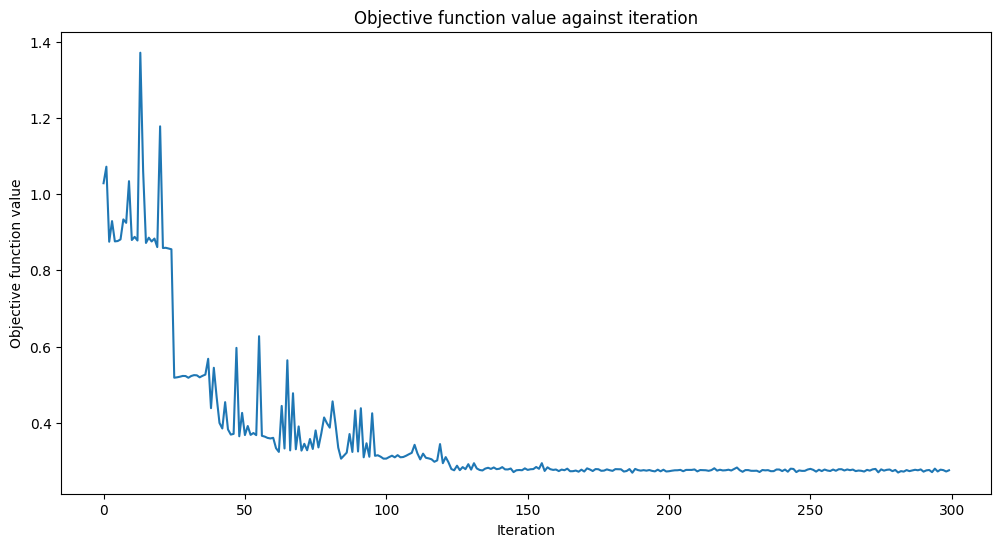

In [139]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
print(x_train)
classifier = classifier.fit(x_train, y_train_1h)

In [140]:
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x_train, y_train_1h), 2)}%")
print(classifier.score(x_test, y_test_1h))

Accuracy from the train data : 93.75%
0.85


In [ ]:
obs_parity = Pauli('Z' * num_features)
obs_one_qubit = Pauli('I' * (num_features - 1) + 'Z')
print(f"Parity observable: {obs_parity}")
print(f"First qubit observable: {obs_one_qubit}")

In [ ]:
paramShiftEstGrad = ParamShiftEstimatorGradient(estimator=estimator)

estimator_qnn = EstimatorQNN(estimator=estimator,
                             circuit=circuit,
                             observables=obs_one_qubit,
                             input_params=input_params,     # if your embedding strategy is not a parametrized circuit
                                                            # (e.g. amplitude encoding) you will have to do some extra work!
                             weight_params=weights_params,  # if you train your embedding as well, the trainable
                                                            # parameters of the embedding must be added
                             gradient=paramShiftEstGrad)

### Forward pass

In [ ]:
# The result of the neural network on a forward pass.
output = estimator_qnn.forward(x, weights)
print(f"Output shape for {len(x)} samples: {output.shape}")
print(f"Output of the forward pass for first sample: {output[0]}")

### Backward pass

In [ ]:
# The result of the neural network on a backward pass
_, weights_grad = estimator_qnn.backward(x, weights)
print(f"Output shape for {len(x)} samples: {weights_grad.shape}")
print(f"Output of the backward pass for first sample: {weights_grad[0]}")

# Train a Neural Network Classifier

In [109]:
def get_one_hot_encoding(y):
    unique_labels = np.unique(y, axis=0)
    y_one_hot = [(np.eye(len(unique_labels), dtype=int)[np.where(unique_labels == y_i)]).reshape(len(unique_labels)) for y_i in y]

    return np.array(y_one_hot)

y_train_1h = get_one_hot_encoding(y_train)
y_test_1h = get_one_hot_encoding(y_test)

print(f"Label {y_train[2]} converted to {y_train_1h[2]}")
print(f"Label {y_train[0]} converted to {y_train_1h[0]}")

Label 0.0 converted to [1 0]
Label 1.0 converted to [0 1]


In [ ]:
def spsa_callback(nfev, params, fval, stepsize, accepted=None):
    """
    Can be used for SPSA and GradientDescent optimizers
    nfev: the number of function evals
    params: the current parameters
    fval: the current function value
    stepsize: size of the update step
    accepted: whether the step was accepted (not used for )
    """
    global spsa_loss_recorder

    if (nfev % 3) == 0:
        spsa_loss_recorder.append(fval)
        # print(f"SPSA Epoch {len(spsa_loss_recorder)}: {fval:.5f}")

In [ ]:
max_itr = 40
spsa_opt = SPSA(maxiter=max_itr, callback=spsa_callback)
spsa_loss_recorder = []
initial_point = np.random.random((len(ansatz.parameters),))
vqc = NeuralNetworkClassifier(neural_network=sampler_qnn,
                              loss=CrossEntropyLoss(),
                              one_hot=True,
                              optimizer=spsa_opt,
                              initial_point=initial_point)
print(x_train[0])
vqc = vqc.fit(x_train, y_train_1h)

In [ ]:
plt.plot(spsa_loss_recorder)
plt.xlabel("Number of epochs")
plt.title("Training loss")

In [ ]:
score_train = vqc.score(x_train, y_train_1h)
score_test = vqc.score(x_test, y_test_1h)
print(f'Score on the train set {score_train}')
print(f'Score on the test set {score_test}')

In [ ]:
y_train_pred = vqc.predict(x_train)
y_test_pred = vqc.predict(x_test)

In [ ]:
train_pred_acc = np.all(y_train_pred == y_train_1h, axis=1)
test_pred_acc = np.all(y_test_pred == y_test_1h, axis=1)

In [ ]:
x_all = np.concatenate((x_train, x_test))
y_all= np.concatenate((y_train_1h, y_test_1h))
y_pred_acc_all = np.concatenate((train_pred_acc, test_pred_acc))

x_b = x_all[np.all(y_all == [1, 0], axis=1)]
x_b_good = x_b[(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]
x_b_bad = x_b[np.logical_not(y_pred_acc_all[np.all(y_all == [1, 0], axis=1)])]

x_r = x_all[np.all(y_all == [0, 1], axis=1)]
x_r_good = x_r[(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]
x_r_bad = x_r[np.logical_not(y_pred_acc_all[np.all(y_all == [0, 1], axis=1)])]

In [ ]:
plt.scatter(x_b_good[:,0], x_b_good[:,1], c='b', marker=".", label="Good class 0")
plt.scatter(x_b_bad[:,0], x_b_bad[:,1], c='b', marker="x", label="Bad class 0")
plt.scatter(x_r_good[:,0], x_r_good[:,1], c='r', marker=".", label="Good class 1")
plt.scatter(x_r_bad[:,0], x_r_bad[:,1], c='r', marker="x", label="Bad class 1")

plt.title("Moon dataset classification")
plt.legend()